In [199]:
from imutils.object_detection import non_max_suppression
import numpy as np
import scipy
from scipy import stats
import time
import cv2
import PIL
from PIL import Image
import IPython
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import pytesseract
import skimage.filters as sf

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
    from io import BytesIO

In [200]:
# USE This method instaed of cv2.imageShow
def showarray(a, fmt='jpeg'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [224]:
argpath = 'images/bib2.jpg'
argeast = 'frozen_east_text_detection.pb'
argmincon = 0.70
# multiply
pi = np.pi
argspad = 1/pi

In [225]:
# load the input image and grab the image dimensions
image = cv2.imread(argpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

orig = image.copy(); roi_crop = image.copy();
(origH, origW) = image.shape[:2]
print('original dimension :',(origH, origW))

# find optimum resize scale
# linear resize : H=32X+C / W=32Y+D

golden_ratio = (1 + 5 ** 0.5) / 2
if origH < 1000 or origW < 1000 : resize_ratio = 1
else : resize_ratio = 3 #golden_ratio
print(resize_ratio)
C = origH%32; D=origW%32
HminusC = origH-C; WminusD = origW-D
HminusC_ratiomod = (HminusC/resize_ratio)/32; WminusD_ratiomod = (WminusD/resize_ratio)/32

argw = 32*int(WminusD_ratiomod);argh = 32*int(HminusC_ratiomod)
print('resize dimension 32X:',argh,argw)

# print(image)

original dimension : (2480, 3508)
3
resize dimension 32X: 800 1152


In [226]:
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (argw, argh)
rW = origW / float(newW)
rH = origH / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]
print((H, W))
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

(800, 1152)


(235.0, 234.0, 234.0)


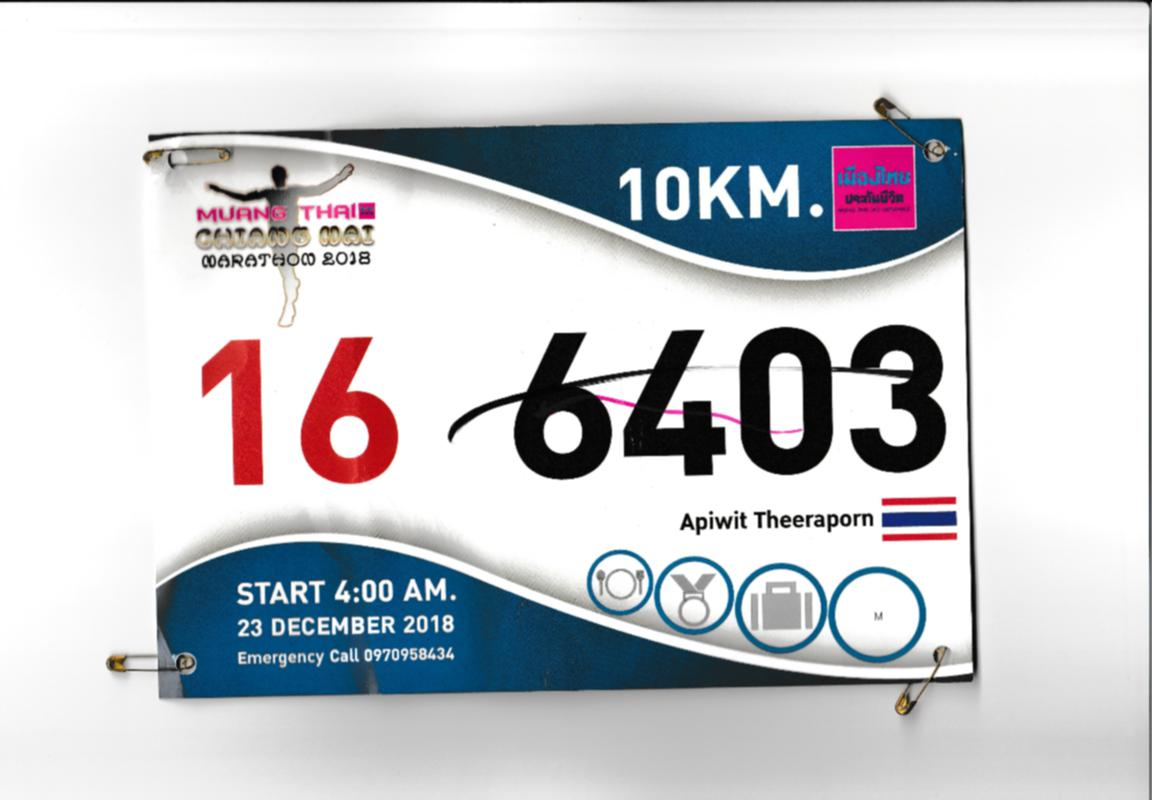

In [227]:
# find average color : Gaussian blur kernel odd --> Median on Median
image = cv2.GaussianBlur(image, (3,3), 0)

# np.average() takes in an axis argument which finds the average across that axis. 
average_color_per_row = np.median(image, axis=0)

# find median across average per row
average_color = np.median(average_color_per_row, axis=0)

# convert back to RGB tuples
average_color = tuple(np.round(average_color,2))
print(average_color)

showarray(image)

In [228]:
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(argeast)

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),average_color, swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

[INFO] loading EAST text detector...
[INFO] text detection took 2.119841 seconds


In [229]:
# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < argmincon:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [230]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
roi=[]; magik_num = 1/pi
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    
    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((endX - startX) * argspad)
    dY = int((endY - startY) * argspad)
    
    # apply padding to each side of the bounding box, respectively
    startX = max(0, startX - int(dX*magik_num*2))
    startY = max(0, startY - int(dY*magik_num))
    endX = min(origW, endX + int(dX*magik_num*2))
    endY = min(origH, endY + int(dY*magik_num))
    
    # extract the actual padded ROI
    tmp = roi_crop[startY:endY, startX:endX] 
    roi.append(tmp);
    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 3)

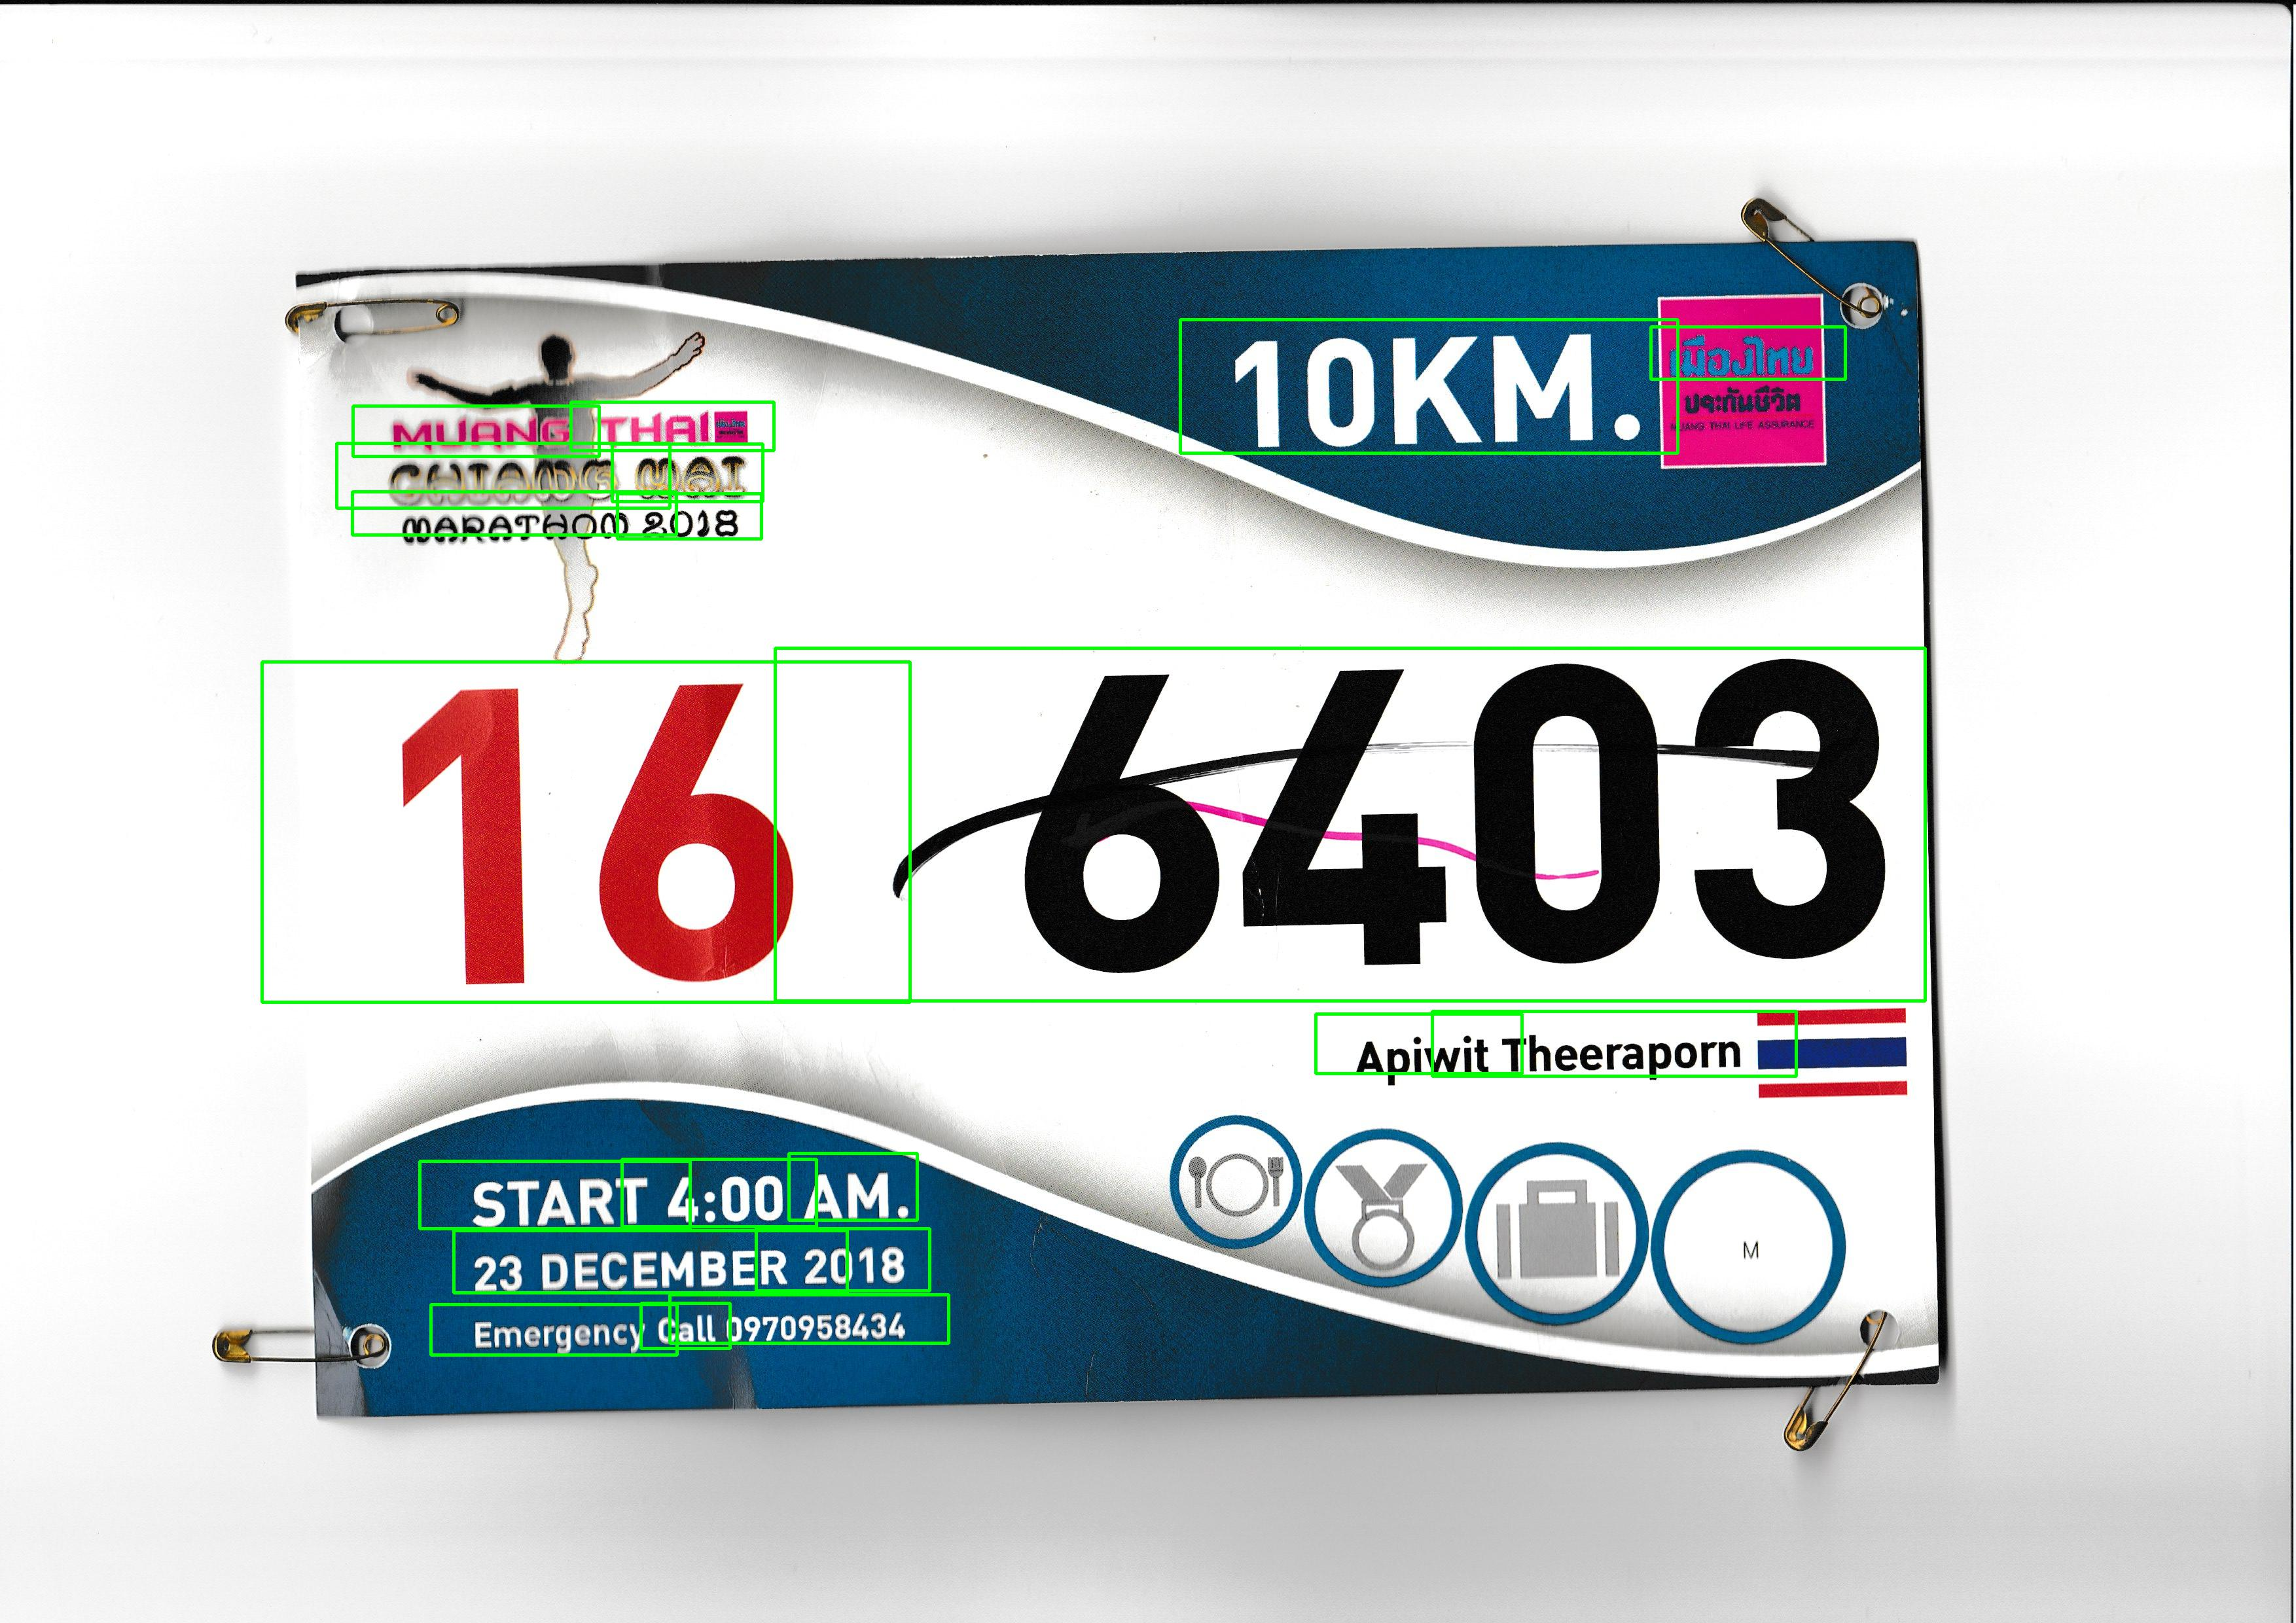

In [231]:
showarray(orig)
# Display the frame until new frame is available
clear_output(wait=True)

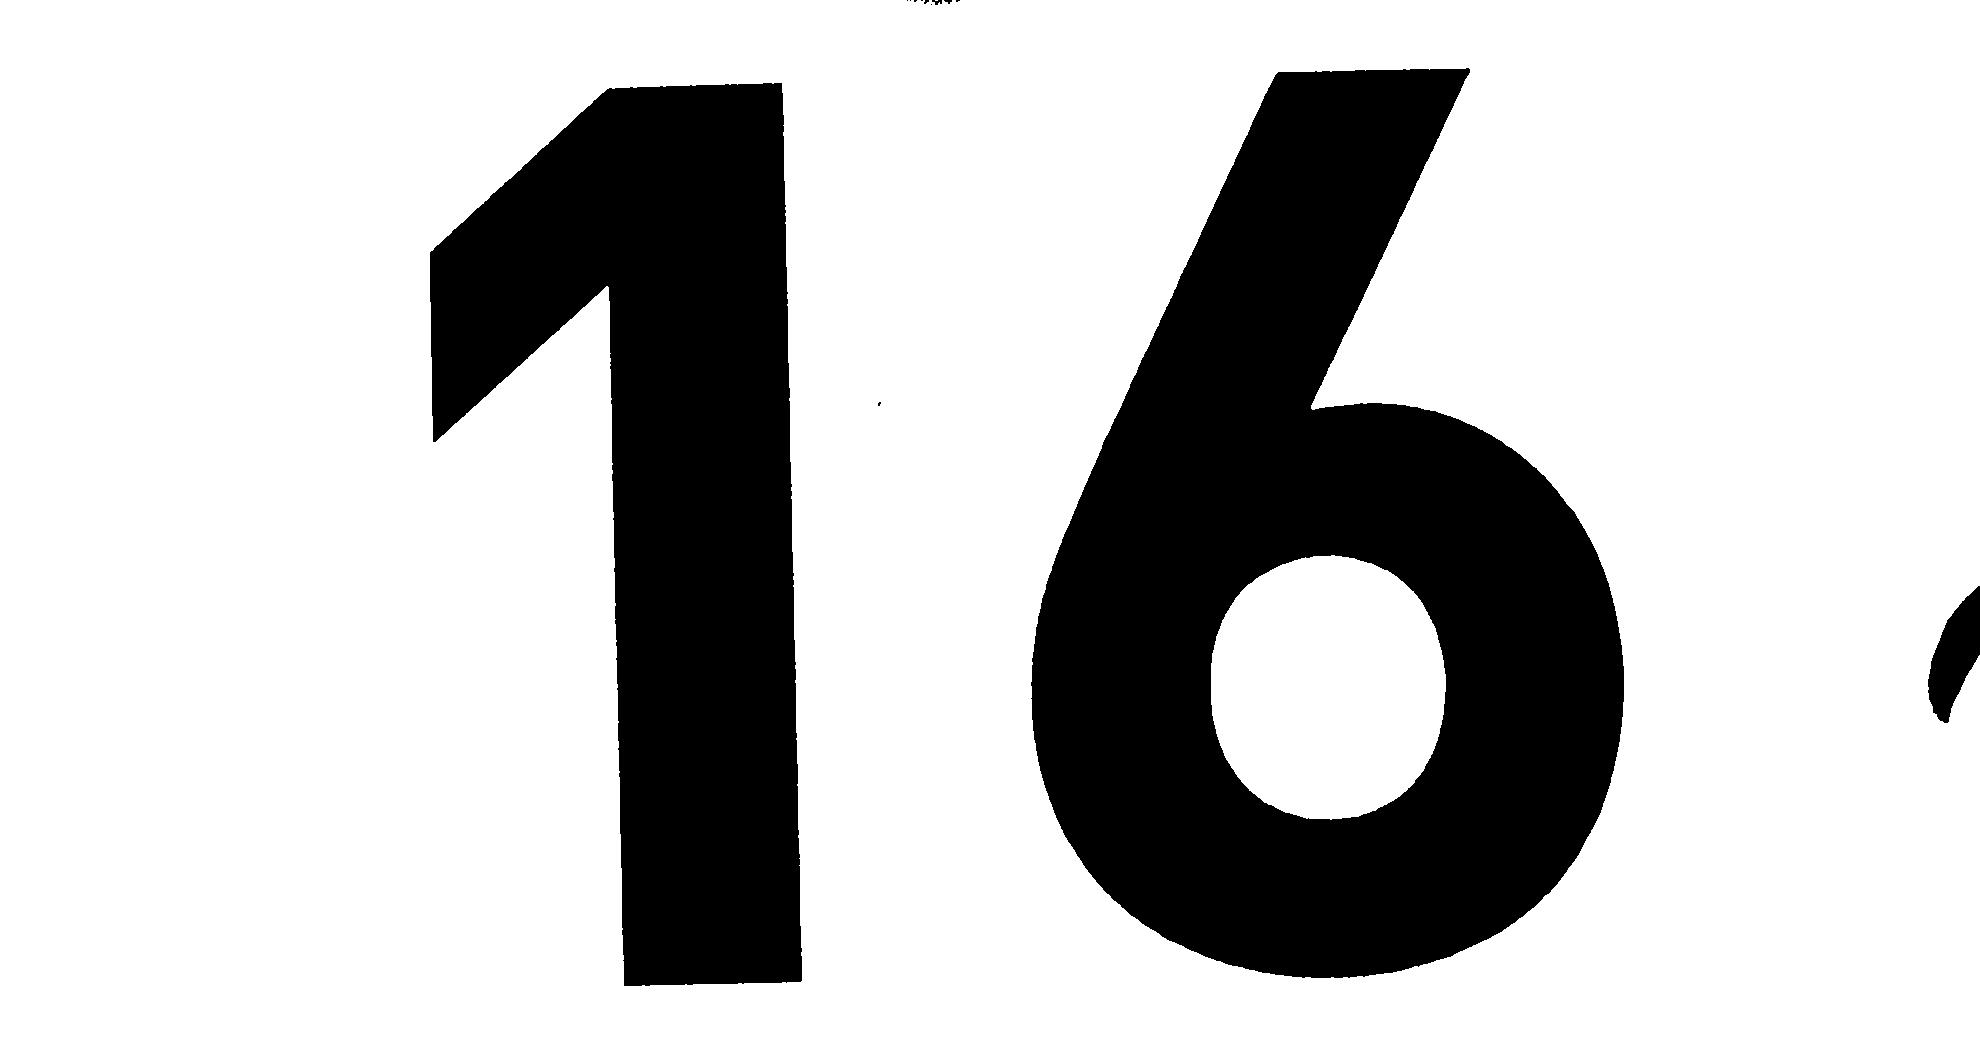

16.


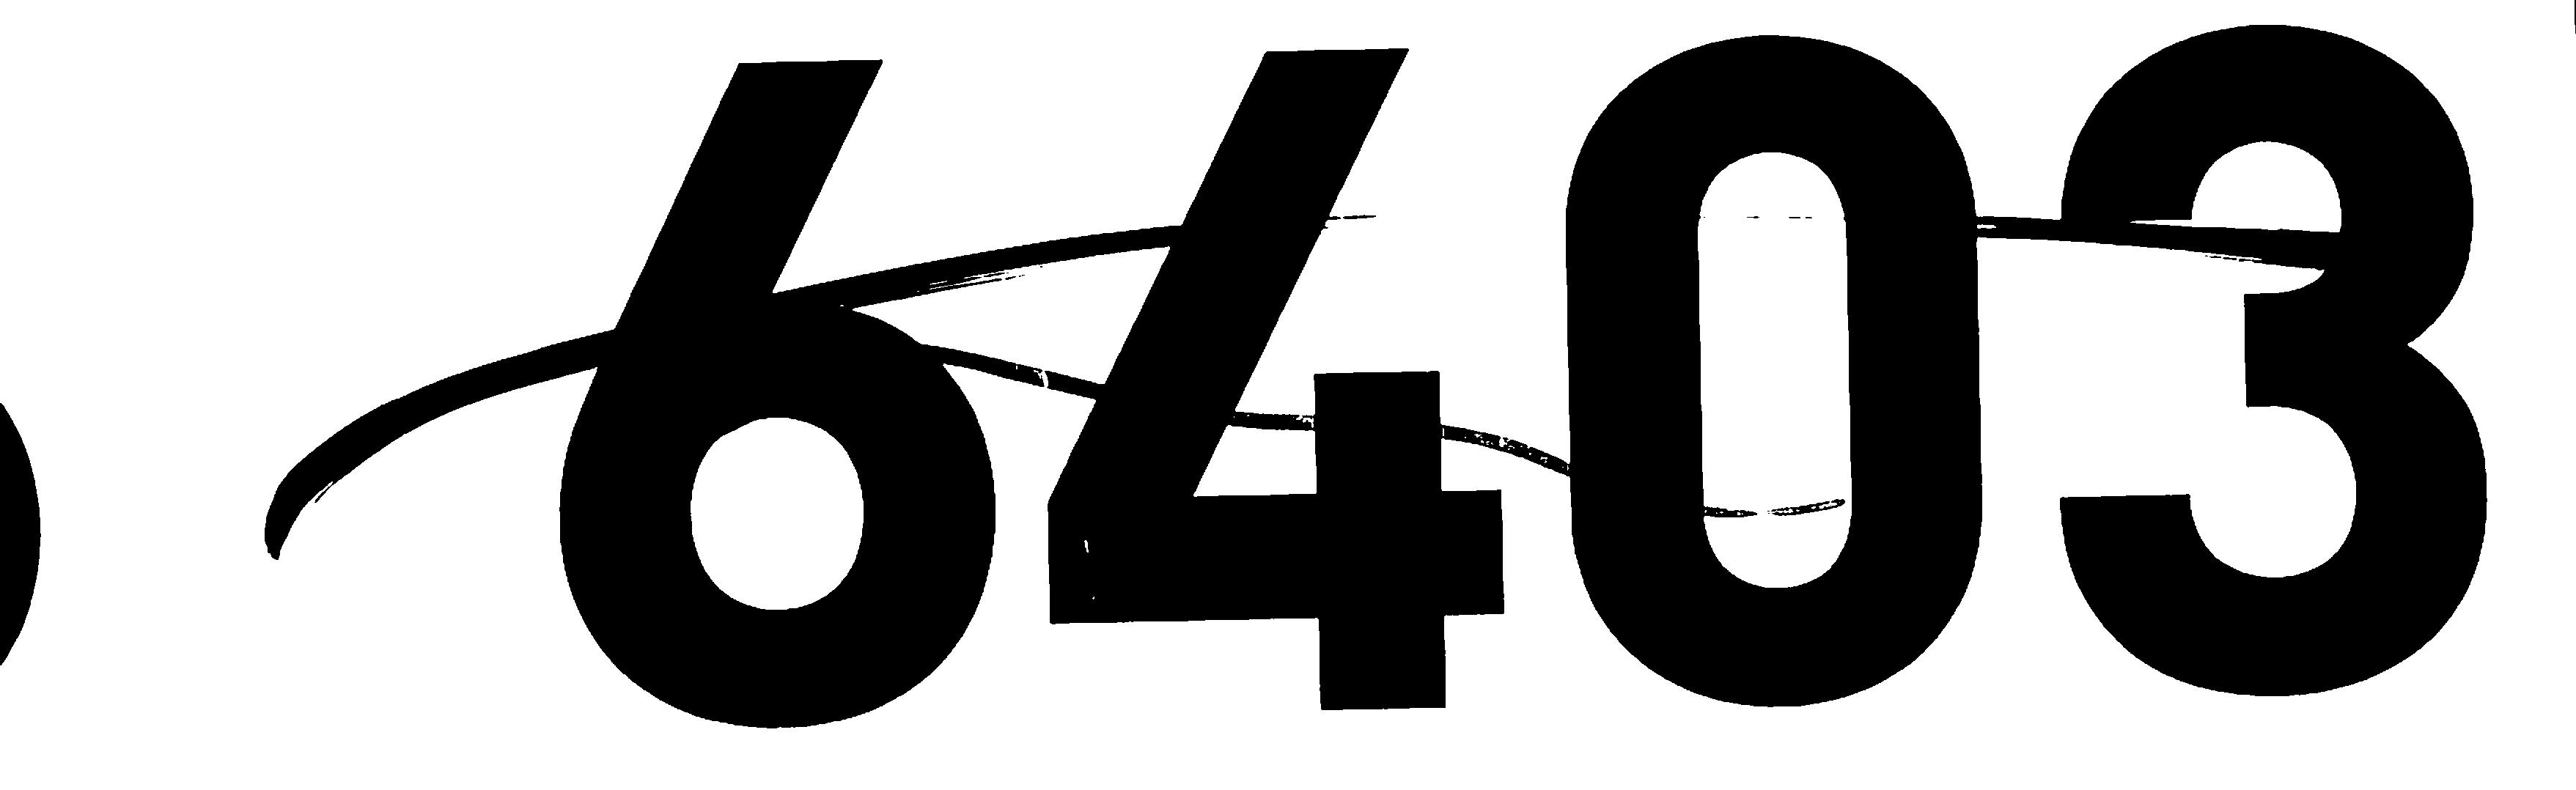

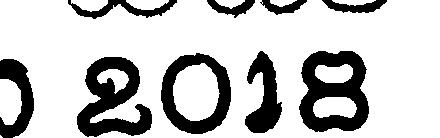

12038


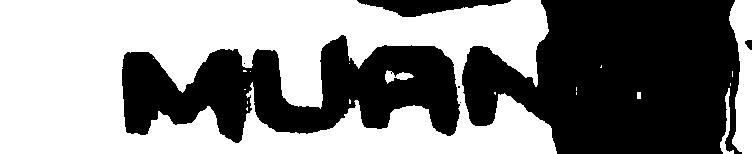

MUNG


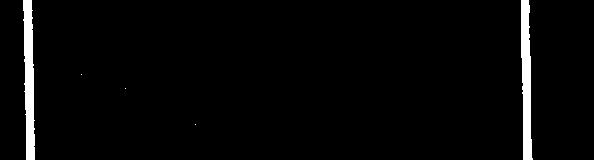

| |


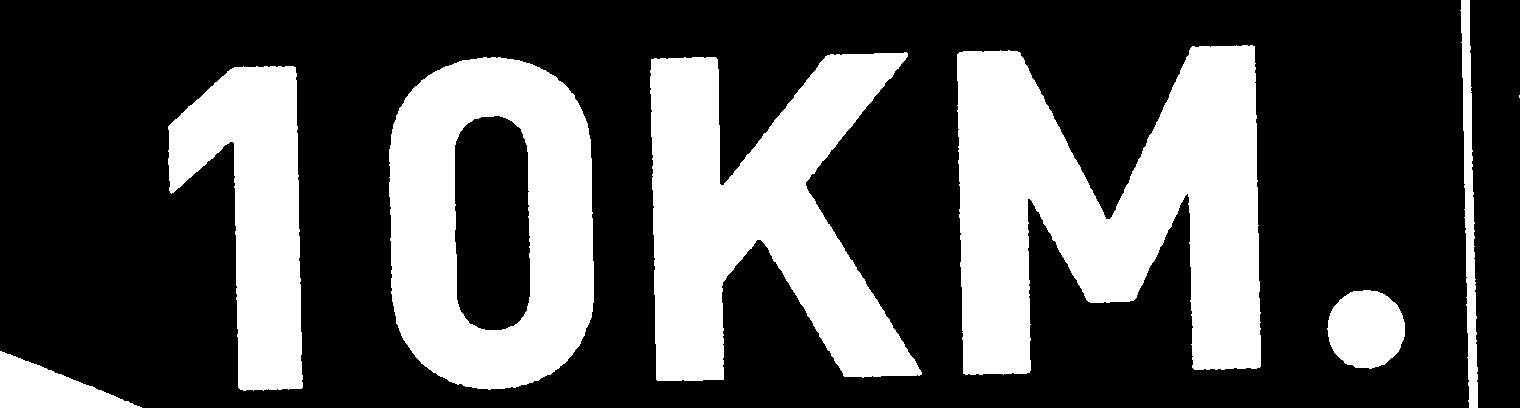

AOKM.


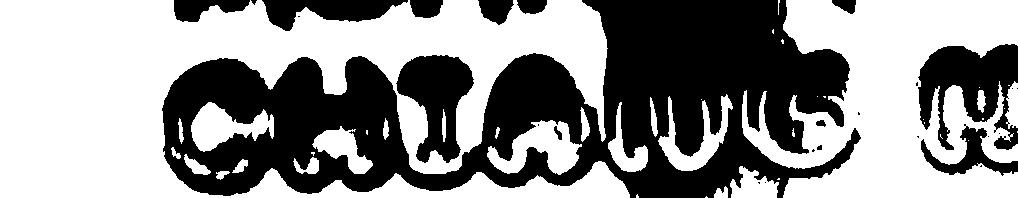

CHIAIUS


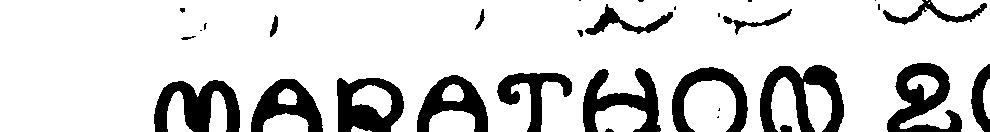

MABDATAOY 2


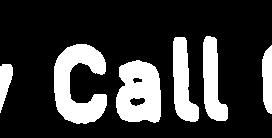

Call |


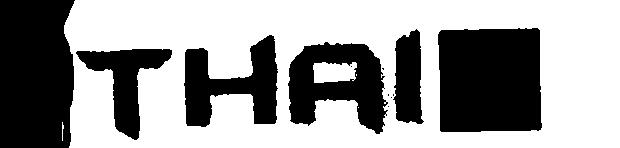

STHAIM


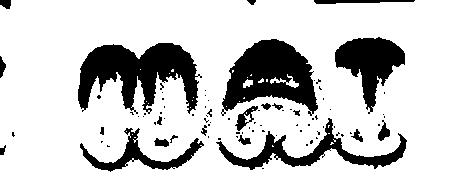

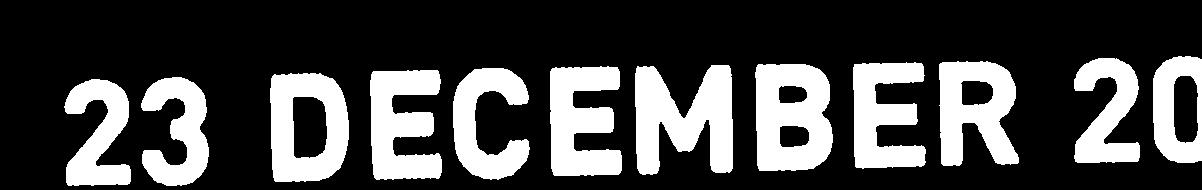

23 DECEMBER 20


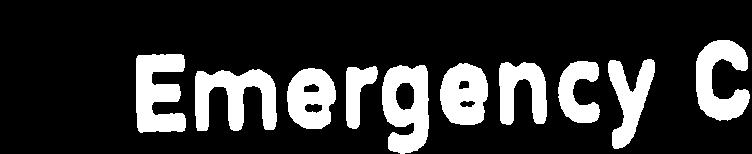

Emergency C


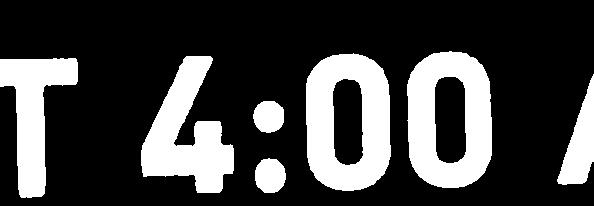

i el ty


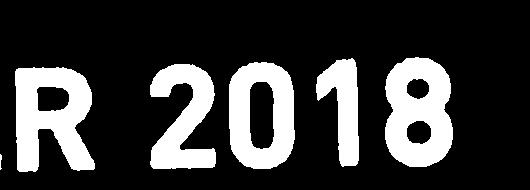

R 2018


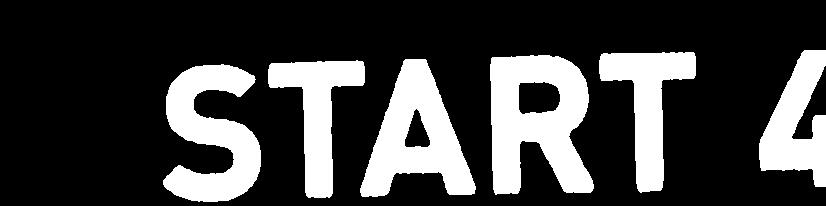

START 4


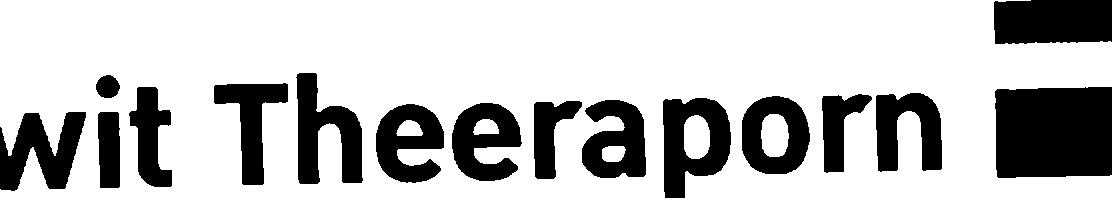

wit Theeraporn -


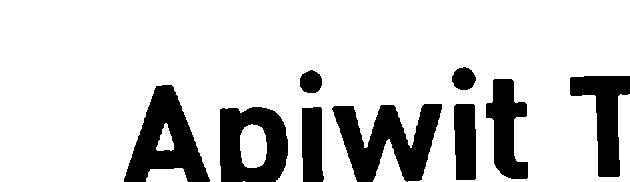

Aviwit T


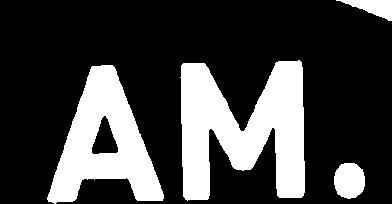

AM.


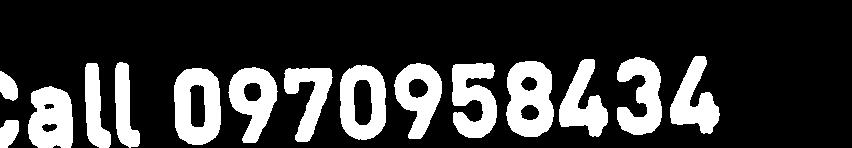

‘all 0970958434


In [232]:
length = len(roi)-1;
while length >= 0:
    img = roi[length]

    # process img for ocr : resizeX2 -> Gray Scale -> mode treshold
    img = cv2.resize(img,None,fx=2,fy=2)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Threshold
    # adaptive gaussian threshold
#     img_agt = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,9,2)
    # adaptive mean threshold
#     img_amt = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,9,2)
    # OTSU threshold
    ret_otsu,img_otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Otsu's thresholding after Gaussian filtering
#     blur = cv2.GaussianBlur(img,(5,5),0)
#     ret_otsug,img_otsug = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
     # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(img_otsu, config=config)
    showarray(img_otsu);
    print(text);
    
    length -= 1